In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt


Cihaz: cuda
Epoch [10/200], Loss: 0.0003
Epoch [20/200], Loss: 0.0006
Epoch [30/200], Loss: 0.0012
Epoch [40/200], Loss: 0.0002
Epoch [50/200], Loss: 0.0003
Epoch [60/200], Loss: 0.0006
Epoch [70/200], Loss: 0.0001
Epoch [80/200], Loss: 0.0000
Epoch [90/200], Loss: 0.0001
Epoch [100/200], Loss: 0.0000
Epoch [110/200], Loss: 0.0002
Epoch [120/200], Loss: 0.0000
Epoch [130/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0002
Epoch [150/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [170/200], Loss: 0.0000
Epoch [180/200], Loss: 0.0002
Epoch [190/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0003


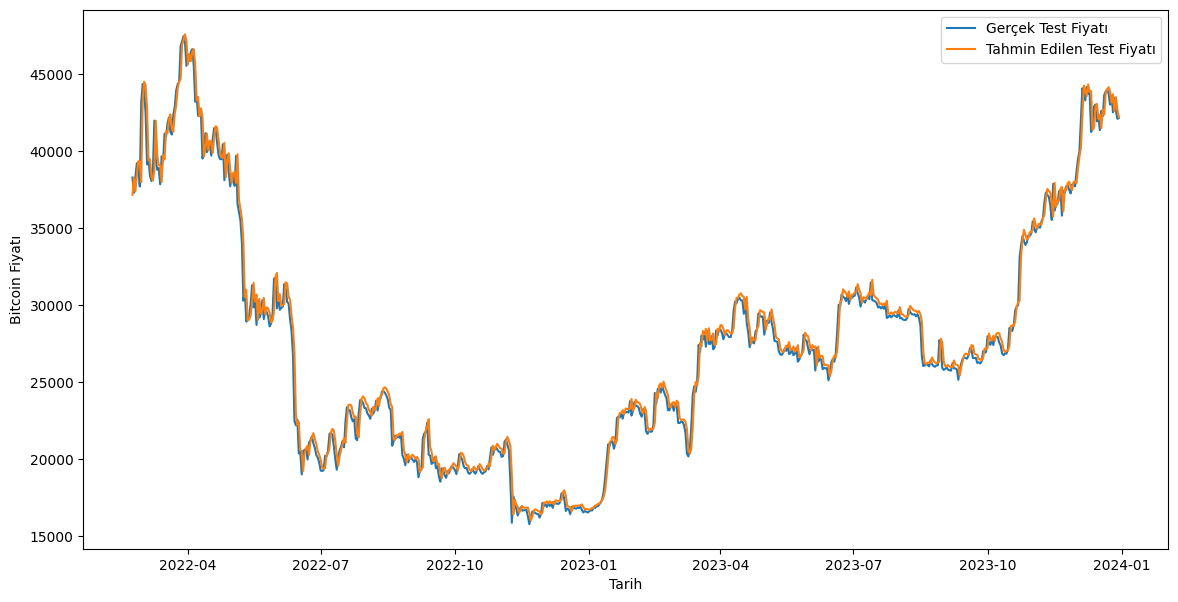

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Cihaz:", device)


data = pd.read_csv("bitcoin_price.csv")  
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
close_data = data[['Close']].values

 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)
 
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # 10 günlük veri ile 
X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

 
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Modeli GPU/CPU üzerinde oluşturma
model = BitcoinPriceLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:

        outputs = model(inputs)
        loss = criterion(outputs, targets)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


model.eval()
train_predictions = []
test_predictions = []



with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.cpu().numpy())


test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))


plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size+seq_length:], y_test, label="Gerçek Test Fiyatı")
plt.plot(data.index[train_size+seq_length:], test_predictions, label="Tahmin Edilen Test Fiyatı")
plt.xlabel("Tarih")
plt.ylabel("Bitcoin Fiyatı")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_predictions)

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")


MAE (Mean Absolute Error): 566.8895
MSE (Mean Squared Error): 691076.1250
RMSE (Root Mean Squared Error): 831.3099
R^2 Score: 0.9886
